In [7]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import argparse
from model import get_model, get_loss, get_optimizer
from image_to_train import bands_to_image, display_image, unpack_numpy_subimages, preprocess_single_train
from tensorflow.python.training import py_checkpoint_reader

In [21]:
x2_weight_path = os.path.join('Weightx2', 'x2.ckpt')
ckpt_reader = tf.train.load_checkpoint(x2_weight_path)
tensor_names = ckpt_reader.get_variable_to_shape_map().keys()
x2_model = get_model()

In [52]:
"""
names of the layers are as follows:
conv_00_w, conv_00_b
conv_??_w, conv_??_b
conv_20_w, conv_20_b

weights end with:
1. 'b', 'w'
2. Adam
3. Adam_1
"""
names_list = []
full_names_list = []
for tensor_name in tensor_names:
    
    # Read the tensor value
    tensor_value = ckpt_reader.get_tensor(tensor_name)
    # print(f"Layer: {tensor_name}, Shape: {tensor_value.shape}")
    
    if tensor_name.endswith('w') or tensor_name.endswith('b'):
        names_list.append(tensor_name)
    full_names_list.append(tensor_name)
        
names_list.sort()
names_list = np.array(names_list)
grouped_names_list = []
for x in range(0, len(names_list), 2):
    grouped_names_list.append([names_list[x], names_list[x+1]])

grouped_names_list = np.array(grouped_names_list)

for i, (b_name, w_name) in enumerate(grouped_names_list):
    b_tensor = ckpt_reader.get_tensor(b_name)
    w_tensor = ckpt_reader.get_tensor(w_name)
    
    x2_model.layers[i].set_weights([w_tensor, b_tensor])

Layer: conv_20_w/Adam, Shape: (3, 3, 64, 4)
Layer: conv_20_w, Shape: (3, 3, 64, 4)
Layer: conv_20_b/Adam, Shape: (4,)
Layer: conv_10_w/Adam_1, Shape: (3, 3, 64, 64)
Layer: conv_10_b/Adam_1, Shape: (64,)
Layer: conv_09_w, Shape: (3, 3, 64, 64)
Layer: conv_09_b/Adam_1, Shape: (64,)
Layer: conv_09_b, Shape: (64,)
Layer: conv_08_b/Adam_1, Shape: (64,)
Layer: conv_08_b/Adam, Shape: (64,)
Layer: conv_08_b, Shape: (64,)
Layer: conv_07_w/Adam, Shape: (3, 3, 64, 64)
Layer: conv_07_w, Shape: (3, 3, 64, 64)
Layer: conv_08_w/Adam_1, Shape: (3, 3, 64, 64)
Layer: conv_07_b/Adam_1, Shape: (64,)
Layer: conv_07_b/Adam, Shape: (64,)
Layer: conv_06_w/Adam_1, Shape: (3, 3, 64, 64)
Layer: conv_06_b, Shape: (64,)
Layer: conv_20_w/Adam_1, Shape: (3, 3, 64, 4)
Layer: conv_09_w/Adam, Shape: (3, 3, 64, 64)
Layer: conv_05_w/Adam_1, Shape: (3, 3, 64, 64)
Layer: conv_05_w, Shape: (3, 3, 64, 64)
Layer: conv_10_b/Adam, Shape: (64,)
Layer: conv_05_b/Adam_1, Shape: (64,)
Layer: conv_10_w, Shape: (3, 3, 64, 64)
Layer: 

In [53]:
test_image = tf.io.read_file(os.path.join('Testx2Color', '0901x2.png'))
test_image = tf.io.decode_png(test_image)
test_train = preprocess_single_train(test_image)
init_test_x = test_train[0]
init_test_y = test_train[1]

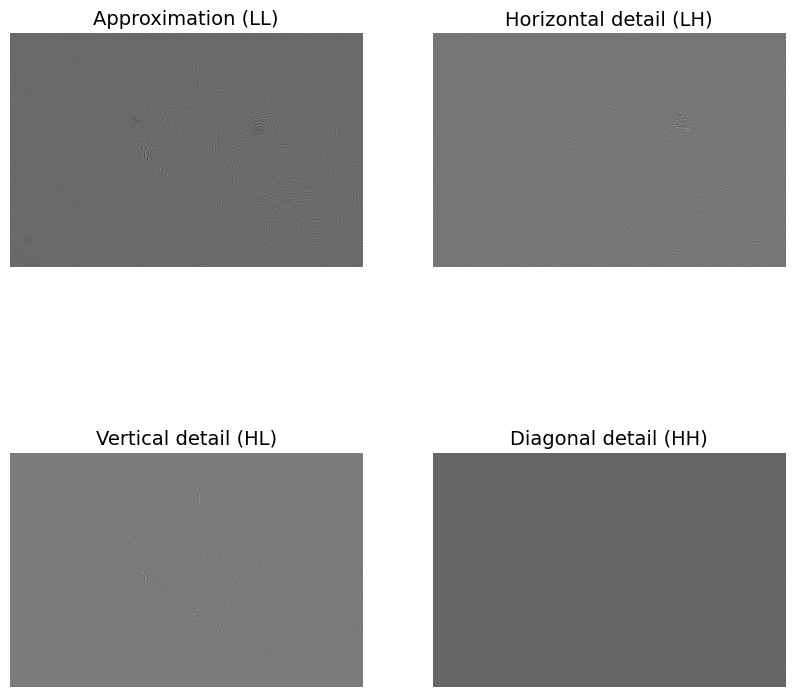

In [54]:
test_x = np.moveaxis(init_test_x, 0, -1)
test_x = tf.expand_dims(test_x, axis=0)

test_out = x2_model(test_x)
test_out = tf.squeeze(test_out)
test_out =np.moveaxis(test_out, -1, 0)
display_image(test_out)

In [55]:
lowres = bands_to_image(init_test_x)
SR = bands_to_image(init_test_x+test_out)
highres = bands_to_image(init_test_x+init_test_y)

In [56]:
# checking PSNR
print('PSNR lr: ',tf.image.psnr(lowres[..., tf.newaxis], highres[..., tf.newaxis], max_val=1.0).numpy())
print('PSNR sr: ', tf.image.psnr(SR[..., tf.newaxis], highres[..., tf.newaxis], max_val=1.0).numpy())

# checking SSIM
print('ssim lr:', tf.image.ssim(lowres[..., tf.newaxis], highres[..., tf.newaxis], max_val=1.0).numpy())
print('ssim sr:', tf.image.ssim(SR[..., tf.newaxis], highres[..., tf.newaxis], max_val=1.0).numpy())

PSNR lr:  35.46879
PSNR sr:  33.750378
ssim lr: 0.93932897
ssim sr: 0.9317912
